In [0]:
pip install catboost

In [0]:
pip install xgboost

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from catboost import cv

import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn import decomposition

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
train_df = pd.read_csv('/content/drive/My Drive/vtb/training_data.csv')
print(train_df.shape)
train_df.head(3)

(2646, 20)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Rarely,Sales,5.0,3,Technical Degree,Male,Sales Executive,Single,54050.0,4.0,14,8.0,0,10.0,2.0,8,7,104,0
1,45,Travel_Rarely,Sales,3.0,3,Life Sciences,Male,Healthcare Representative,Single,60740.0,0.0,14,8.0,0,9.0,2.0,8,3,1,0
2,51,Travel_Rarely,Sales,23.0,3,Medical,Female,Research Scientist,Married,192720.0,9.0,20,8.0,0,18.0,2.0,10,2,7,1


In [6]:
test_df = pd.read_csv('/content/drive/My Drive/vtb/test_data.csv')
print(test_df.shape)
test_df.head(3)

(1764, 20)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Id
0,40,Travel_Rarely,Research & Development,23.0,3,Medical,Female,Laboratory Technician,Married,45020.0,8.0,12,8.0,2,15.0,0.0,7,3,7,0
1,35,Travel_Rarely,Human Resources,15.0,1,Life Sciences,Male,Research Scientist,Married,79880.0,1.0,18,8.0,0,4.0,3.0,4,1,1,1
2,59,Travel_Rarely,Research & Development,4.0,2,Life Sciences,Male,Research Scientist,Single,166813.0,6.0,21,8.0,1,25.0,2.0,9,5,4,2


In [0]:
def preprocess(df, is_train=False):
    
    #clean anomally big values in YearsAtCompany
    max_years_in_company = max(df['YearsAtCompany'])
    
    for val, i in enumerate(df['YearsWithCurrManager']):
        if val  > max_years_in_company:
            train_df['YearsWithCurrManager'][i] = 2
        
    #drop StandardHours as it contains 1 value
    df = df.drop(['StandardHours'], axis=1)
    
    #clean anomally big and little values in Age
    for val, i in enumerate(df['Age']):
        if val > 70 or val < 18:
            df['Age'][i] = 32

    if is_train:
        y = df['Attrition']
        X = df.drop(['Attrition'], axis=1)
        return X, y
    else:
        X = df.drop(['Id'], axis=1)
        return X

In [0]:
data, labels = preprocess(train_df, True)
test_data = preprocess(test_df)

### Analysis

In [9]:
class_per_column = {}
for column in train_df.columns:
    class_per_column[column] = [train_df[column].nunique()]
class_per_column_df = pd.DataFrame(data=class_per_column)
class_per_column_df.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,43,3,3,30,5,6,2,9,3,1714,11,43,1,4,41,8,37,16,51,2


### Some feautures are nominal categorical

In [0]:
label_cnt = train_df['Attrition'].value_counts()

In [11]:
label_cnt

0    2224
1     422
Name: Attrition, dtype: int64

#### Data is imbalanced => good decission to use tree based classifiers

### Model 1. XGBoost with PCA after one hot encoding

##### The paper of idea of PCA after one hot encoding https://arxiv.org/pdf/1909.00154.pdf

In [0]:
#onehot encoding of nominal categorical feautures
cat_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

def df_to_onehot(df):
    for column in cat_features:
        gen_onehot_features = pd.get_dummies(data[column])
        df = df.drop([column], axis=1)
        
        #for JobRole feature using PCA to reduce dim from 9 to 3, other feautures are already have a few dim
        if column == 'JobRole':
            pca = decomposition.PCA(n_components=3)
            pca.fit(gen_onehot_features)
            X = pca.transform(gen_onehot_features)
            
            df = pd.concat([df, pd.DataFrame(X, columns=['f1', 'f2', 'f3'])], axis=1)
        else:
            df = pd.concat([df, gen_onehot_features], axis=1)
    
    col = df['Human Resources'].iloc[:, :-1]
    df = df.drop(['Human Resources'], axis=1)
    df = pd.concat([df, col], axis=1)
    
    return df

In [0]:
train_one_hot = df_to_onehot(data)
test_one_hot = df_to_onehot(test_data)

In [0]:
def xgboost_tune_params(df_train):
    total_params =({'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'tree_method': 'hist',
             'seed':777,
             'nthread':8
              }) 
             
    params_to_tune = [('eta', [0.1, 0.03, 0.5, 0.7]),
                  ('max_depth',[2,3,4,5,6, 8, 10]),
                  ('subsample', [0.8,0.9,1]),
                  ('colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1]),
                  ('max_bin',[25,30,40,60,80,100, 200, 256, 300, 500, 1000]),
                  ('min_child_weight',[1,5,7,10,15,50,75,100,130,160,200]),
                  ('lambda',[0.01,0.1,1,3,5])
            ]
    
    max_auc = 0
    for param_pair in params_to_tune:
        param_name = param_pair[0]  
        param_auc_l = []
        param_val_l = []
        param_iter_n_l = []
        for param_value in param_pair[1]:   
            total_params[param_name] = param_value
            result = []    

            cross_val = xgb.cv(total_params, df_train, 
                          early_stopping_rounds=50, maximize=True, 
                          num_boost_round=1000, nfold=5, stratified=True, seed=777, verbose_eval=False)
            
            best_iter_vec = np.array(cross_val[cross_val['test-auc-mean']==cross_val['test-auc-mean'].max()])[0]
            
            best_iter_n = best_iter_vec[0]
            best_mean_auc = best_iter_vec[1]
            best_std_auc = best_iter_vec[2]
            
            
            param_auc_l.append(best_mean_auc)
            param_val_l.append(param_value)
            param_iter_n_l.append(best_iter_n)
        best_auc = np.max(np.array(param_auc_l))
        best_val = param_val_l[np.argmax(np.array(param_auc_l))]
        best_iter = param_iter_n_l[np.argmax(np.array(param_auc_l))]
        
        total_params[param_name] = best_val
        total_params['iterations'] = best_iter
        
        plt.plot(param_val_l, param_auc_l)
        plt.legend(param_name)
        plt.show()
        print("AUC on tuned ", param_name, " : ", best_auc)
        
        max_auc = max(max_auc, best_auc)
    
    return total_params, max_auc

In [0]:
train_matr = xgb.DMatrix(train_one_hot, labels)
params, max_auc = xgboost_tune_params(train_matr)

### Catboost Classifier

In [0]:
cat_features = ['BusinessTravel', 'Department', 'EducationField',
               'Gender', 'JobRole', 'MaritalStatus']

In [0]:
def catboost_tune_params(pool):
    total_params =({'eval_metric': 'AUC',
             'thread_count':8, 
             'random_seed':241,
              'loss_function':'Logloss'
             }) 
    
    params_to_tune = [('learning_rate', [0.01, 0.03, 0.05, 0.07, 0.1]),
                  ('depth', [2,3,4,6,8]),
                  ('subsample', [0.8, 0.9, 1])
                 ]
    
    max_auc = 0
    for param_pair in params_to_tune:
        param_name = param_pair[0] 
        param_auc_l = []
        param_val_l = []
        param_iter_n_l = []
        for param_value in param_pair[1]:      
            total_params[param_name] = param_value
            result = []  

            cross_val = cv(pool, total_params, early_stopping_rounds = 20, iterations=1000, fold_count=5,
                           stratified=True, verbose=False) 
            best_iter_vec = np.array(cross_val[cross_val['test-AUC-mean']==cross_val['test-AUC-mean'].max()])[0]
            
            best_iter_n = best_iter_vec[0]
            best_mean_auc = best_iter_vec[1]
            best_std_auc = best_iter_vec[2]
            
            
            param_auc_l.append(best_mean_auc)
            param_val_l.append(param_value)
            param_iter_n_l.append(best_iter_n)

        best_auc = np.max(np.array(param_auc_l))
        best_val = param_val_l[np.argmax(np.array(param_auc_l))]
        best_iter = param_iter_n_l[np.argmax(np.array(param_auc_l))]
        
        total_params[param_name] = best_val
        total_params['iterations'] = best_iter
        
        plt.plot(param_val_l, param_auc_l)
        plt.legend(param_name)
        plt.show()
        print("AUC on tuned ", param_name, " : ", best_auc)
        
        max_auc = max(max_auc, best_auc)
        
    return total_params, max_auc

Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)


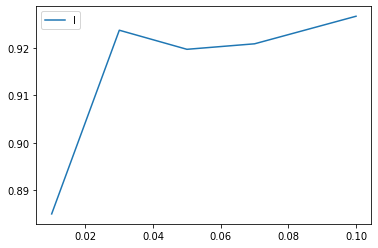

AUC on tuned  learning_rate  :  0.926776006626965
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)


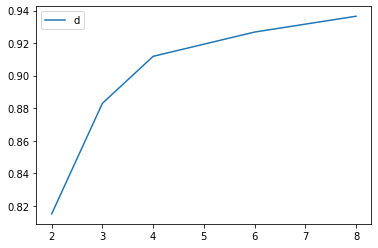

AUC on tuned  depth  :  0.9364891367621044
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)
Stopped by overfitting detector  (20 iterations wait)


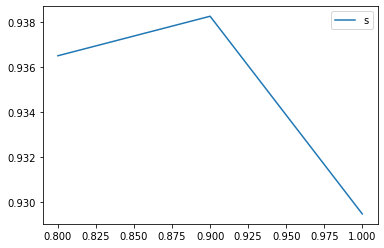

AUC on tuned  subsample  :  0.9382436669981283


In [18]:
pool = Pool(data, labels, cat_features)
params, max_auc = catboost_tune_params(pool)

In [19]:
params

{'depth': 8,
 'eval_metric': 'AUC',
 'iterations': 363.0,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'random_seed': 241,
 'subsample': 0.9,
 'thread_count': 8}

In [20]:
max_auc

0.9382436669981283

### Test evaluation

In [0]:
model = CatBoostClassifier(eval_metric=params['eval_metric'], thread_count=params['thread_count'], random_seed=params['random_seed'], loss_function=params['loss_function'],
                           learning_rate=params['learning_rate'], iterations=params['iterations'], depth=params['depth'], subsample=params['subsample'])
model.fit(data, labels, cat_features=cat_features)

In [0]:
sub_predictions = model.predict(test_data)

In [0]:
sub_df = pd.DataFrame(sub_predictions, columns=["Label"])

In [0]:
sub_df.to_csv('/content/drive/My Drive/vtb/sub.csv', index=False) 